In [13]:
import libpysal
import geopandas as gpd
import pandas
%matplotlib inline

import os

In [15]:
os.chdir('C:/Users/renan/Desktop/full_count_2010')
df = pandas.read_csv('std_2010_fullcount.csv', encoding = "ISO-8859-1", sep = ",")
map_url = 'https://raw.githubusercontent.com/renanxcortes/inequality-segregation-supplementary-files/master/Tracts_grouped_by_County/06065.json'
gdf = gpd.read_file(map_url)

In [16]:
df = df.loc[df.county == "Riverside County"][['trtid10','tract','pop10','nhblk10']]

gdf['INTGEOID10'] = pandas.to_numeric(gdf["GEOID10"])
df_map = gdf.merge(df, left_on = 'INTGEOID10', right_on = 'trtid10')
df_mp = df_map[['GEOID10', 'tract', 'geometry', 'pop10', 'nhblk10']]
df_mp.head()

,GEOID10,tract,geometry,pop10,nhblk10
0,06065042012,Census Tract 420.12,"POLYGON ((-117.319414 33.902109, -117.322528 3...",6242,677
1,06065041911,Census Tract 419.11,"POLYGON ((-117.504056 33.800257, -117.502758 3...",10258,844
2,06065041910,Census Tract 419.10,"POLYGON ((-117.472451 33.762031, -117.475661 3...",6342,405
3,06065040816,Census Tract 408.16,"POLYGON ((-117.5285 33.89736, -117.529425 33.8...",2594,346
4,06065040815,Census Tract 408.15,"POLYGON ((-117.501299 33.89424899999999, -117....",3586,429


# Build a weights matrix using libpysal

this functionality will be in PySAL in december, but for now let's use libpysal

In [17]:
w = libpysal.weights.Queen.from_dataframe(df_mp, ids=df_mp.GEOID10.values.tolist())

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1bcd434b048>)

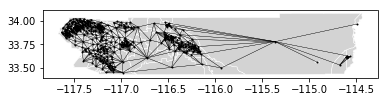

In [18]:
ax = gdf.plot(color='lightgrey', edgecolor='w', linewidth=.5)
w.plot(gdf, indexed_on='GEOID10', 
       ax=ax, node_kws=dict(s=1), edge_kws=dict(linewidth=.25))

# Make the adjacency table

This is an edge-focused representation of the data, where each row corresponds to one edge in the weights matrix between `focal` and `neighbor`, with a weight of `weight`:

In [19]:
adjlist = w.to_adjlist()
adjlist.head()

,focal,neighbor,weight
0,06065030101,06065030104,1.0
1,06065030101,06065042209,1.0
2,06065030101,06065030103,1.0
3,06065030101,06065030502,1.0
4,06065030101,06065042300,1.0


# Use a double-join to get the geometries for each

This may look like magic, but take it line by line. The first merge+drop pairs up the "focal" to its geometry and drops the extra focal index column. The second pairs up the "neighbour" to its geometry and drops the extra neighbour index olumn. At the end, we'll have a table with geometries for the focal and the neighbour. 

**please** split this up if you don't see how this works, so you can piece it back together and see how the double-join works.

In [20]:
adjlist = \
adjlist.merge(gdf[['GEOID10', 'geometry']], left_on='focal', right_on='GEOID10', how='left')\
       .drop('GEOID10', axis=1)\
       .merge(gdf[['GEOID10', 'geometry']], left_on='neighbor', right_on='GEOID10', 
              how='left', suffixes=("_focal", "_neighbor"))\
       .drop('GEOID10', axis=1)

In [21]:
adjlist.head()

,focal,neighbor,weight,geometry_focal,geometry_neighbor
0,06065030101,06065030104,1.0,"POLYGON ((-117.352089 34.001387, -117.351409 3...","POLYGON ((-117.357366 33.993489, -117.358277 3..."
1,06065030101,06065042209,1.0,"POLYGON ((-117.352089 34.001387, -117.351409 3...","POLYGON ((-117.32895 33.997528, -117.333554 33..."
2,06065030101,06065030103,1.0,"POLYGON ((-117.352089 34.001387, -117.351409 3...","POLYGON ((-117.360787 33.989439, -117.361834 3..."
3,06065030101,06065030502,1.0,"POLYGON ((-117.352089 34.001387, -117.351409 3...","POLYGON ((-117.357474 33.993306, -117.357238 3..."
4,06065030101,06065042300,1.0,"POLYGON ((-117.352089 34.001387, -117.351409 3...","POLYGON ((-117.352089 34.001387, -117.352907 3..."


# Get intersection lengths

Now, since we've got each pair of observations, we can get the intersections between the two columns. But, let's use geopandas to its fullest to make sure we have the fastest operations possible:

In [22]:
adjlist = geopandas.GeoDataFrame(adjlist, geometry='geometry_focal')
adjlist['geometry_neighbor'] = geopandas.GeoSeries(adjlist.geometry_neighbor)

OK. Then, we can get the intersection over pairs of rows using geopandas's built-in `intersection` methods:

In [23]:
adjlist.intersection?

In [24]:
adjlist['shared_boundary'] = adjlist.geometry_focal.intersection(adjlist.set_geometry('geometry_neighbor'))

In [25]:
adjlist.head()

,focal,neighbor,weight,geometry_focal,geometry_neighbor,shared_boundary
0,06065030101,06065030104,1.0,"POLYGON ((-117.352089 34.001387, -117.351409 3...","POLYGON ((-117.357366 33.993489, -117.358277 3...","(LINESTRING (-117.357366 33.993489, -117.35552..."
1,06065030101,06065042209,1.0,"POLYGON ((-117.352089 34.001387, -117.351409 3...","POLYGON ((-117.32895 33.997528, -117.333554 33...","(LINESTRING (-117.352089 34.001387, -117.35140..."
2,06065030101,06065030103,1.0,"POLYGON ((-117.352089 34.001387, -117.351409 3...","POLYGON ((-117.360787 33.989439, -117.361834 3...","LINESTRING (-117.357474 33.993306, -117.357366..."
3,06065030101,06065030502,1.0,"POLYGON ((-117.352089 34.001387, -117.351409 3...","POLYGON ((-117.357474 33.993306, -117.357238 3...","(LINESTRING (-117.348719 33.997585, -117.35066..."
4,06065030101,06065042300,1.0,"POLYGON ((-117.352089 34.001387, -117.351409 3...","POLYGON ((-117.352089 34.001387, -117.352907 3...",POINT (-117.352089 34.001387)


# And voila:

The length of these shared boundary segments can be grabbed from the `length` attribute of the geodataframe;

In [26]:
adjlist.set_geometry('shared_boundary').length.head()

0    0.009501
1    0.011300
2    0.000212
3    0.011658
4    0.000000
dtype: float64

# Be sure

Your original data looks like it's in lat/lon, so this makes the results in terms of degrees latitude. Usually, you really need to make sure the data is projected before you use these kinds of computations. That said, this is the way I would get the length of a shared boundary. 

# If you want to stuff it back into a weights matrix:

We need to go backwards from adjlist to weights:

In [27]:
adjlist['weight'] = adjlist.set_geometry('shared_boundary').length

In [28]:
length_weighted_w = libpysal.weights.W.from_adjlist(adjlist[['focal', 'neighbor', 'weight']])

In [29]:
length_weighted_w.weights

{'06065030101': [0.009500864897628962,
  0.011300374153086188,
  0.00021249235280206845,
  0.011658115060941512,
  0.0],
 '06065030103': [0.012643405282661552,
  0.019390141329248642,
  0.00021249235280206845,
  0.005144162278875177,
  0.014787261004276957],
 '06065030104': [0.019390141329248642,
  0.009500864897628962,
  0.0,
  0.018478269456457388,
  0.008189469469229552,
  0.025647380721938454],
 '06065030200': [0.02744365819559728,
  0.0616970922130153,
  0.008189469469229554,
  0.01478726100427696,
  0.040908536622916374,
  0.005953801850583532,
  0.0005527865772666194],
 '06065030300': [0.018977150628697165,
  0.01264340528266155,
  0.0073901777079571716,
  0.027443658195597277,
  0.02017253783867193],
 '06065030400': [0.012280582079211573,
  0.01897715062869717,
  0.020390530570099537,
  0.016434911868201098,
  0.0021125837261480145,
  0.0036532188361066984],
 '06065030501': [0.012280582079211573,
  0.008660259176266375,
  0.008633000057920516,
  0.014817386348505612,
  0.008278

# Be sure:

there may be very minor asymmetries depending on the machine precision. 

In [30]:
length_weighted_w.asymmetries[0]

(0, 7)

In [31]:
length_weighted_w.id_order[0], length_weighted_w.id_order[7]

('06065030101', '06065030502')

In [32]:
length_weighted_w[length_weighted_w.id_order[0]]

{'06065030104': 0.009500864897628962,
 '06065042209': 0.011300374153086188,
 '06065030103': 0.00021249235280206845,
 '06065030502': 0.011658115060941512,
 '06065042300': 0.0}

In [33]:
length_weighted_w[length_weighted_w.id_order[7]]

{'06065030501': 0.0082781413784908,
 '06065030300': 0.007390177707957172,
 '06065030400': 0.016434911868201098,
 '06065030503': 0.014996453165731009,
 '06065030103': 0.005144162278875177,
 '06065030101': 0.011658115060941514,
 '06065042209': 0.014852098735372122}

If you look, the weights are the same up until the last digit. 

# Bulding the function

In [57]:
w = libpysal.weights.Queen.from_dataframe(df_mp, ids = df_mp.index.tolist())

In [58]:
gdf['index'] = gdf.index

In [59]:
adjlist = w.to_adjlist()
adjlist.head()

,focal,neighbor,weight
0,0,416,1.0
1,0,247,1.0
2,0,268,1.0
3,0,429,1.0
4,0,175,1.0


In [60]:
adjlist = \
adjlist.merge(gdf[['index', 'geometry']], left_on='focal', right_on='index', how='left')\
       .drop('index', axis=1)\
       .merge(gdf[['index', 'geometry']], left_on='neighbor', right_on='index', 
              how='left', suffixes=("_focal", "_neighbor"))\
       .drop('index', axis=1)

In [61]:
adjlist.head()

,focal,neighbor,weight,geometry_focal,geometry_neighbor
0,0,416,1.0,"POLYGON ((-117.319414 33.902109, -117.322528 3...","POLYGON ((-117.374508 33.901737, -117.38044 33..."
1,0,247,1.0,"POLYGON ((-117.319414 33.902109, -117.322528 3...","POLYGON ((-117.331541 33.916458, -117.331245 3..."
2,0,268,1.0,"POLYGON ((-117.319414 33.902109, -117.322528 3...","POLYGON ((-117.31399 33.898499, -117.31416 33...."
3,0,429,1.0,"POLYGON ((-117.319414 33.902109, -117.322528 3...","POLYGON ((-117.292139 33.920173, -117.292018 3..."
4,0,175,1.0,"POLYGON ((-117.319414 33.902109, -117.322528 3...","POLYGON ((-117.300452 33.916658, -117.291939 3..."


In [64]:
# Transforming from pandas to geopandas
adjlist = geopandas.GeoDataFrame(adjlist, geometry='geometry_focal')
adjlist['geometry_neighbor'] = geopandas.GeoSeries(adjlist.geometry_neighbor)

In [70]:
# Getting the shared boundaries
adjlist['shared_boundary'] = adjlist.geometry_focal.intersection(adjlist.set_geometry('geometry_neighbor'))
adjlist.head()

,focal,neighbor,weight,geometry_focal,geometry_neighbor,shared_boundary
0,0,416,1.0,"POLYGON ((-117.319414 33.902109, -117.322528 3...","POLYGON ((-117.374508 33.901737, -117.38044 33...","(LINESTRING (-117.331541 33.916458, -117.33191..."
1,0,247,1.0,"POLYGON ((-117.319414 33.902109, -117.322528 3...","POLYGON ((-117.331541 33.916458, -117.331245 3...","(LINESTRING (-117.331237 33.901913, -117.33114..."
2,0,268,1.0,"POLYGON ((-117.319414 33.902109, -117.322528 3...","POLYGON ((-117.31399 33.898499, -117.31416 33....","(LINESTRING (-117.319414 33.902109, -117.32252..."
3,0,429,1.0,"POLYGON ((-117.319414 33.902109, -117.322528 3...","POLYGON ((-117.292139 33.920173, -117.292018 3...","(LINESTRING (-117.332667 33.91922, -117.332127..."
4,0,175,1.0,"POLYGON ((-117.319414 33.902109, -117.322528 3...","POLYGON ((-117.300452 33.916658, -117.291939 3...","(LINESTRING (-117.300452 33.916658, -117.30046..."


In [71]:
adjlist.set_geometry('shared_boundary').length.head()

0    0.002991
1    0.014604
2    0.011861
3    0.033268
4    0.033052
dtype: float64

In [ ]:
# Putting it back to a matrix

In [72]:
adjlist['weight'] = adjlist.set_geometry('shared_boundary').length
length_weighted_w = libpysal.weights.W.from_adjlist(adjlist[['focal', 'neighbor', 'weight']])

In [73]:
length_weighted_w

In [75]:
length_weighted_w.full()[0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.07549512, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.07549512, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [76]:
w.full()

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 0.]]),
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,


In [81]:
def return_length_weighted_w(data):
    '''
    data: a geopandas dataframe with a 'geometry' column
    '''
    data['index'] = data.index
    w = libpysal.weights.Queen.from_dataframe(data, ids = data.index.tolist())
    
    adjlist = w.to_adjlist().merge(gdf[['index', 'geometry']], left_on='focal', right_on='index', how='left')\
              .drop('index', axis=1)\
              .merge(gdf[['index', 'geometry']], left_on='neighbor', right_on='index', 
                     how='left', suffixes=("_focal", "_neighbor"))\
              .drop('index', axis=1)
    
    # Transforming from pandas to geopandas
    adjlist = geopandas.GeoDataFrame(adjlist, geometry='geometry_focal')
    adjlist['geometry_neighbor'] = geopandas.GeoSeries(adjlist.geometry_neighbor)
    
    # Getting the shared boundaries
    adjlist['shared_boundary'] = adjlist.geometry_focal.intersection(adjlist.set_geometry('geometry_neighbor'))
    
    # Putting it back to a matrix
    adjlist['weight'] = adjlist.set_geometry('shared_boundary').length
    length_weighted_w = libpysal.weights.W.from_adjlist(adjlist[['focal', 'neighbor', 'weight']])
    
    return length_weighted_w

In [82]:
return_length_weighted_w(df_mp)

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [85]:
return_length_weighted_w(df_mp).full()[0]

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.07549512, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.07549512, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [84]:
"""
Useful functions for segregation metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu>, Levi Wolf <levi.john.wolf@bristol.ac.uk> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd
import libpysal
import geopandas as gpd


def _return_length_weighted_w(data):
    """
    Returns a PySAL weights object that the weights represent the length of the commom boudary of two areal units that share border.

    Parameters
    ----------

    data          : a geopandas DataFrame with a 'geometry' column.

    Notes
    -----
    Currently it's not making any projection

    """
    
    if ('geometry' not in data.columns):    
        raise ValueError('The input data has to have a column named geometry')
    
    data['index'] = data.index
    w = libpysal.weights.Queen.from_dataframe(data, ids = data.index.tolist())
    
    adjlist = w.to_adjlist().merge(data[['index', 'geometry']], left_on='focal', right_on='index', how='left')\
              .drop('index', axis=1)\
              .merge(data[['index', 'geometry']], left_on='neighbor', right_on='index', 
                     how='left', suffixes=("_focal", "_neighbor"))\
              .drop('index', axis=1)
    
    # Transforming from pandas to geopandas
    adjlist = gpd.GeoDataFrame(adjlist, geometry='geometry_focal')
    adjlist['geometry_neighbor'] = gpd.GeoSeries(adjlist.geometry_neighbor)
    
    # Getting the shared boundaries
    adjlist['shared_boundary'] = adjlist.geometry_focal.intersection(adjlist.set_geometry('geometry_neighbor'))
    
    # Putting it back to a matrix
    adjlist['weight'] = adjlist.set_geometry('shared_boundary').length
    length_weighted_w = libpysal.weights.W.from_adjlist(adjlist[['focal', 'neighbor', 'weight']])
    
    return length_weighted_w
